# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [21]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [22]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [23]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(784, 128)
        # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(128, 256)
        # Вихідний шар
    self.output_layer = DenseLayer(256, 10)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.output_layer(x, activation=1)
    return x

In [24]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # ...
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
# Отримаємо список оптимізованих параметрів
  trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [28]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y).numpy()
        current_accuracy = accuracy(pred, batch_y).numpy()

        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)

        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")



Step 100, Loss: 179.1436, Accuracy: 0.7656
Step 200, Loss: 162.2777, Accuracy: 0.8086
Step 300, Loss: 140.5564, Accuracy: 0.8633
Step 400, Loss: 158.5614, Accuracy: 0.8164
Step 500, Loss: 149.1369, Accuracy: 0.8594
Step 600, Loss: 131.1934, Accuracy: 0.8281
Step 700, Loss: 68.2864, Accuracy: 0.9219
Step 800, Loss: 73.6715, Accuracy: 0.9023
Step 900, Loss: 68.9537, Accuracy: 0.9102
Step 1000, Loss: 94.6996, Accuracy: 0.8984
Step 1100, Loss: 67.8283, Accuracy: 0.9258
Step 1200, Loss: 91.3468, Accuracy: 0.8828
Step 1300, Loss: 86.8456, Accuracy: 0.9258
Step 1400, Loss: 74.3933, Accuracy: 0.9102
Step 1500, Loss: 102.7735, Accuracy: 0.9102
Step 1600, Loss: 91.0915, Accuracy: 0.9023
Step 1700, Loss: 81.0851, Accuracy: 0.9062
Step 1800, Loss: 101.8323, Accuracy: 0.8906
Step 1900, Loss: 73.3372, Accuracy: 0.9141
Step 2000, Loss: 67.9620, Accuracy: 0.9102
Step 2100, Loss: 95.3609, Accuracy: 0.9180
Step 2200, Loss: 91.2785, Accuracy: 0.9141
Step 2300, Loss: 62.6717, Accuracy: 0.9219
Step 2400, L

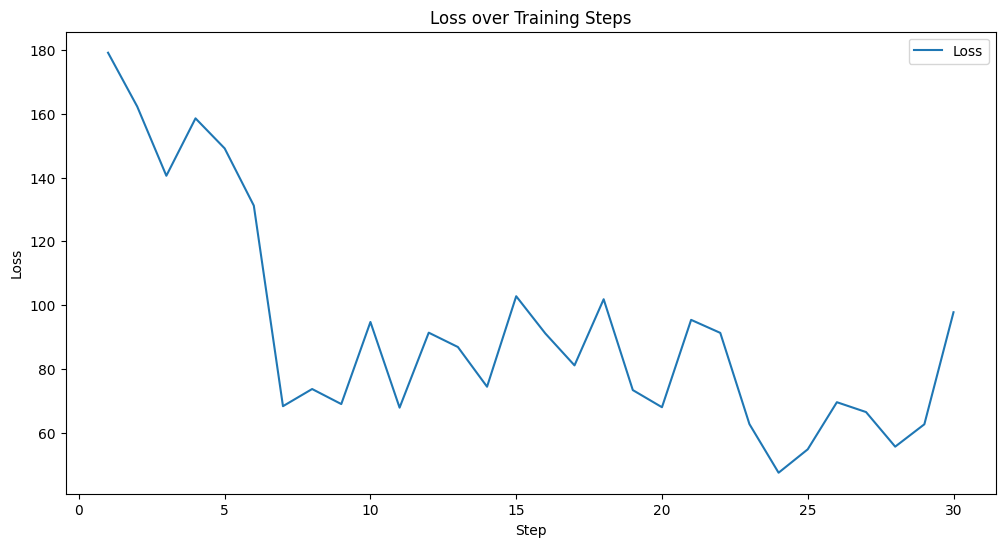

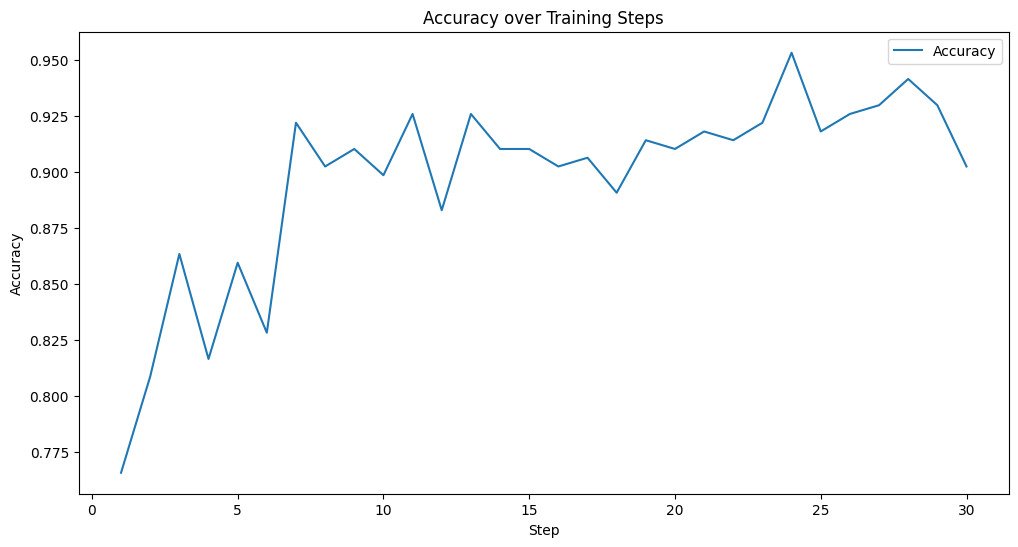

In [29]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Training Steps')
plt.legend()
plt.show()
# Виведіть графік точності
# Місце для вашого коду
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy over Training Steps')
plt.legend()
plt.show()

In [30]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
# Місце для вашого коду
def evaluate_model(neural_net, x_test, y_test):
    pred = neural_net(x_test)
    test_accuracy = accuracy(pred, y_test).numpy()
    return test_accuracy

test_accuracy = evaluate_model(neural_net, x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9058


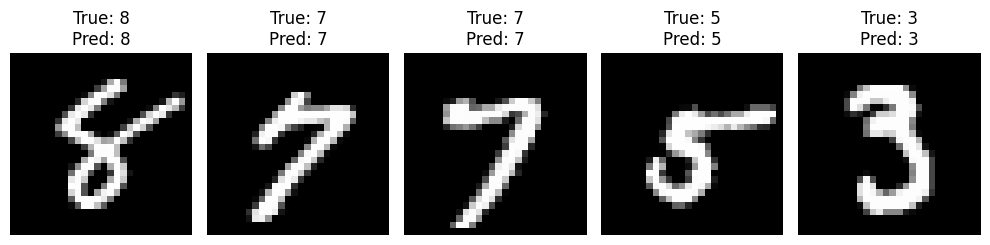

In [31]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду

# Вибір 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(x_test.shape[0], 5, replace=False)
sample_x = x_test[random_indices]
sample_y = y_test[random_indices]

# Передбачення на основі навченого нейромережі
predictions = neural_net(sample_x)

# Відображення зображень та відповідей нейронної мережі
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_x[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_y[i]}\nPred: {np.argmax(predictions[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()




In [33]:

# Оцінка точності на 10 випадкових зображеннях
test_indices = np.random.choice(x_test.shape[0], 10, replace=False)
test_sample_x = x_test[test_indices]
test_sample_y = y_test[test_indices]

In [34]:
test_sample_predictions = neural_net(test_sample_x)
correct_predictions = np.sum(np.argmax(test_sample_predictions, axis=1) == test_sample_y)
total_predictions = len(test_sample_y)

print(f"Accuracy on 10 random test images: {correct_predictions / total_predictions:.4f}")


Accuracy on 10 random test images: 0.9000


In [35]:
# Висновок про помилки нейронної мережі
errors = total_predictions - correct_predictions
print(f"Number of errors: {errors} out of {total_predictions}")

Number of errors: 1 out of 10


In [44]:
predictions = neural_net(x_test)
predicted_labels = np.argmax(predictions, axis=1)

In [45]:
from sklearn.metrics import classification_report
# Виведення метрик якості
report = classification_report(y_test, predicted_labels, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.90      0.91      1032
           3       0.90      0.87      0.88      1010
           4       0.88      0.91      0.90       982
           5       0.86      0.86      0.86       892
           6       0.90      0.93      0.92       958
           7       0.93      0.90      0.91      1028
           8       0.86      0.87      0.87       974
           9       0.86      0.89      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



Можна зробити висновок, що наша нейромережа гарно навчається про що свідчить наш classification_report , а саме для кожного класу всі метрики досить хороші,